In [1]:
import pandas as pd

In [3]:
import os
import pandas as pd

# Define dataset paths
dir = r"D:\final year project\new parking\parking\clf-data"


# Function to create a DataFrame from a given directory
def create_df(directory):
    data = []
    for class_name in os.listdir(directory):  # Class names are folder names
        class_path = os.path.join(directory, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                
                # Check if it's a valid image file
                if image_file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                    data.append([image_path, class_name])

    return pd.DataFrame(data, columns=["image_path", "class"])

# Create train and test DataFrames
df = create_df(dir)



In [4]:
df

,image_path,class
0,D:\final year project\new parking\parking\clf-...,empty
1,D:\final year project\new parking\parking\clf-...,empty
2,D:\final year project\new parking\parking\clf-...,empty
3,D:\final year project\new parking\parking\clf-...,empty
4,D:\final year project\new parking\parking\clf-...,empty
...,...,...
6085,D:\final year project\new parking\parking\clf-...,not_empty
6086,D:\final year project\new parking\parking\clf-...,not_empty
6087,D:\final year project\new parking\parking\clf-...,not_empty
6088,D:\final year project\new parking\parking\clf-...,not_empty


In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import LabelEncoder

# Image preprocessing parameters
IMG_SIZE = (128, 128)  # Resize images to 128x128

# Function to load images and encode labels
def load_images_and_labels(df):
    images = []
    labels = []

    for index, row in df.iterrows():
        image_path = row["image_path"]
        label = row["class"]

        # Read the image in grayscale mode
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)  # Resize image
            img = img / 255.0  # Normalize pixel values (0-1)
            images.append(img)
            labels.append(label)

    # Convert lists to NumPy arrays
    images = np.array(images, dtype=np.float32)  # Convert list to NumPy array
    images = np.expand_dims(images, axis=-1)  # Add channel dimension (H, W, 1)

    # Encode labels: empty -> 0, not_empty -> 1
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # `empty` -> 0, `not_empty` -> 1
    
    return images, labels

# Load images and labels
X, y = load_images_and_labels(df)  # Assuming `df` is your dataset

# Print the shapes
print("X shape:", X.shape)  # Expected: (num_samples, 128, 128, 1)
print("y shape:", y.shape)  # Expected: (num_samples,)

# Save the preprocessed NumPy arrays (optional)
np.save("X.npy", X)
np.save("y.npy", y)


X shape: (6090, 128, 128, 1)
y shape: (6090,)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load preprocessed data
X = np.load("X.npy")
y = np.load("y.npy")

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='tanh'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.8),  # Prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification (empty or not_empty)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


C:\Users\kisha\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 47s 276ms/step - accuracy: 0.7574 - loss: 0.5181 - val_accuracy: 0.9647 - val_loss: 0.1841
Epoch 2/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.9614 - loss: 0.1695 - val_accuracy: 0.9910 - val_loss: 0.0516
Epoch 3/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 275ms/step - accuracy: 0.9870 - loss: 0.0585 - val_accuracy: 0.9795 - val_loss: 0.0401
Epoch 4/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 278ms/step - accuracy: 0.9919 - loss: 0.0377 - val_accuracy: 0.9992 - val_loss: 0.0057
Epoch 5/5
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - accuracy: 0.9951 - loss: 0.0249 - val_accuracy: 0.9992 - val_loss: 0.0027
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9994 - loss: 0.0021
Test Accuracy: 99.92%


In [8]:
# Save the trained model
model.save('cnn_model.h5')  # .h5 file format is commonly used for Keras models

print("Model saved to cnn_model.h5")


Model saved to cnn_model.h5


In [9]:
import cv2
import os

# Path to the video file
video_path = "D:\\final year project\\new parking\\parking\\parking_crop.mp4"

# Path where frames will be saved
frames_dir = "D:\\final year project\\new parking\\parking\\vedioframes"

# Create the frames directory if it doesn't exist
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Initialize video capture
cap = cv2.VideoCapture(video_path)

# Frame counter to name the frames uniquely
frame_count = 0

# Loop to read and save frames
while cap.isOpened():
    ret, frame = cap.read()
    
    # If frame is read correctly
    if not ret:
        break

    # Save frame as an image in the specified directory
    frame_filename = os.path.join(frames_dir, f'frame_{frame_count:04d}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_count += 1

# Release the video capture object
cap.release()

print(f"Frames saved to {frames_dir}")


Frames saved to D:\final year project\new parking\parking\vedioframes


# Trial 1

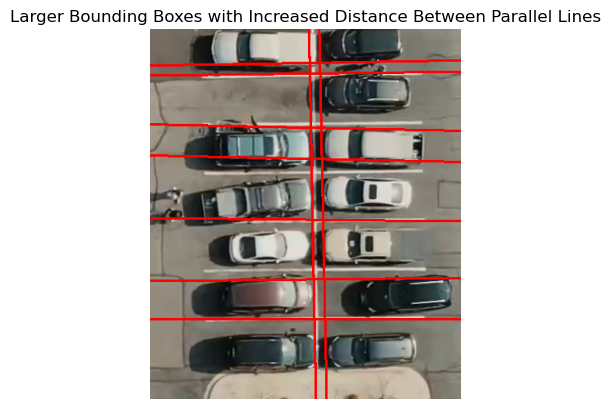

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur before edge detection (increase kernel size for smoother edges)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply Canny edge detection with lower threshold to catch more edges
edges = cv2.Canny(blurred, 50, 200)

# Use morphological operations to close gaps and make edges more continuous
kernel = np.ones((5, 5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

# Use Hough Line Transform to detect straight lines with adjusted parameters
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw the lines on
line_image = np.copy(image)

# Function to extend lines to the edges of the image with offset (larger bounding box)
def extend_line(x1, y1, x2, y2, image_width, image_height, offset=20):
    # Calculate the slope (m) of the line
    if x2 - x1 != 0:  # To avoid division by zero
        slope = (y2 - y1) / (x2 - x1)
        # Extend the line to the left edge (x = 0)
        x1_new = 0
        y1_new = int(y1 - slope * x1)
        # Extend the line to the right edge (x = image_width)
        x2_new = image_width
        y2_new = int(y1 + slope * (x2_new - x1))
        
        # Adjust the lines by adding an offset (spread them out more)
        x1_new -= offset
        x2_new += offset
    else:
        # If the line is vertical (slope = infinity), extend it vertically with offset
        x1_new, x2_new = x1, x2
        y1_new, y2_new = 0, image_height
        y1_new -= offset
        y2_new += offset
        
    return (x1_new, y1_new, x2_new, y2_new)

# Function to filter and merge lines with wider distance
def filter_and_merge_lines(lines, angle_tol=2, distance_tol=50, image_width=1920, image_height=1080, offset=50):
    filtered_lines = []
    
    # Filter out horizontal and vertical lines and merge nearby ones
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate the angle of the line
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        
        # Allow only horizontal (0° or 180°) and vertical (90° or 270°) lines
        if abs(angle) < angle_tol or abs(angle - 180) < angle_tol:  # Horizontal
            # Extend the horizontal lines to the edges of the image with offset
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, image_width, image_height, offset)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'h'))
        elif abs(angle - 90) < angle_tol or abs(angle - 270) < angle_tol:  # Vertical
            # Extend the vertical lines to the edges of the image with offset
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, image_width, image_height, offset)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'v'))

    # Merge close lines by checking their distance
    merged_lines = []
    for line in filtered_lines:
        x1, y1, x2, y2, orientation = line
        merged = False
        
        # Compare with existing merged lines to check for proximity
        for merged_line in merged_lines:
            mx1, my1, mx2, my2, _ = merged_line
            if orientation == 'h':  # Merge horizontal lines
                if abs(y1 - my1) < distance_tol and abs(y2 - my2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((min(x1, mx1), y1, max(x2, mx2), y2, orientation))
                    merged = True
                    break
            elif orientation == 'v':  # Merge vertical lines
                if abs(x1 - mx1) < distance_tol and abs(x2 - mx2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((x1, min(y1, my1), x2, max(y2, my2), orientation))
                    merged = True
                    break
        
        if not merged:
            merged_lines.append((x1, y1, x2, y2, orientation))
    
    return merged_lines

# Filter and merge lines with larger bounding boxes
merged_lines = filter_and_merge_lines(lines, image_width=image.shape[1], image_height=image.shape[0], offset=50)

# Draw the extended and merged lines with larger bounding boxes
for line in merged_lines:
    x1, y1, x2, y2, orientation = line
    if orientation == 'h':  # Horizontal line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    elif orientation == 'v':  # Vertical line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display the image with larger bounding boxes
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Larger Bounding Boxes with Increased Distance Between Parallel Lines")
plt.axis('off')  # Hide axes for better visualization
plt.show()


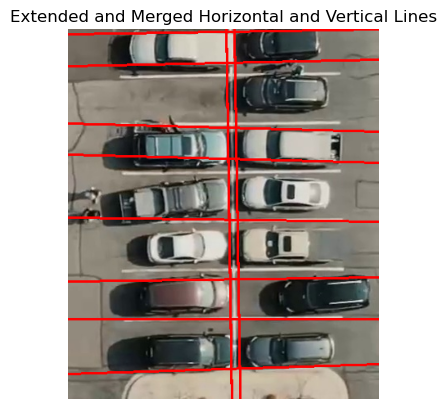

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur before edge detection (increase kernel size for smoother edges)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply Canny edge detection with lower threshold to catch more edges
edges = cv2.Canny(blurred, 50, 200)

# Use morphological operations to close gaps and make edges more continuous
kernel = np.ones((5, 5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

# Use Hough Line Transform to detect straight lines with adjusted parameters
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw the lines on
line_image = np.copy(image)

# Function to extend lines to the edges of the image
def extend_line(x1, y1, x2, y2, image_width, image_height):
    # Calculate the slope (m) of the line
    if x2 - x1 != 0:  # To avoid division by zero
        slope = (y2 - y1) / (x2 - x1)
        # Extend the line to the left edge (x = 0)
        x1_new = 0
        y1_new = int(y1 - slope * x1)
        # Extend the line to the right edge (x = image_width)
        x2_new = image_width
        y2_new = int(y1 + slope * (x2_new - x1))
    else:
        # If the line is vertical (slope = infinity), extend it vertically
        x1_new, x2_new = x1, x2
        y1_new, y2_new = 0, image_height
    return (x1_new, y1_new, x2_new, y2_new)

# Function to filter horizontal and vertical lines and merge nearby ones
def filter_and_merge_lines(lines, angle_tol=2, distance_tol=30, image_width=1920, image_height=1080):
    filtered_lines = []
    
    # Filter out horizontal and vertical lines and merge nearby ones
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calculate the angle of the line
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        
        # Allow only horizontal (0° or 180°) and vertical (90° or 270°) lines
        if abs(angle) < angle_tol or abs(angle - 180) < angle_tol:  # Horizontal
            # Extend the horizontal lines to the edges of the image
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, image_width, image_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'h'))
        elif abs(angle - 90) < angle_tol or abs(angle - 270) < angle_tol:  # Vertical
            # Extend the vertical lines to the edges of the image
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, image_width, image_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'v'))

    # Merge close lines by checking their distance
    merged_lines = []
    for line in filtered_lines:
        x1, y1, x2, y2, orientation = line
        merged = False
        
        # Compare with existing merged lines to check for proximity
        for merged_line in merged_lines:
            mx1, my1, mx2, my2, _ = merged_line
            if orientation == 'h':  # Merge horizontal lines
                if abs(y1 - my1) < distance_tol and abs(y2 - my2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((min(x1, mx1), y1, max(x2, mx2), y2, orientation))
                    merged = True
                    break
            elif orientation == 'v':  # Merge vertical lines
                if abs(x1 - mx1) < distance_tol and abs(x2 - mx2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((x1, min(y1, my1), x2, max(y2, my2), orientation))
                    merged = True
                    break
        
        if not merged:
            merged_lines.append((x1, y1, x2, y2, orientation))
    
    return merged_lines

# Filter and merge lines
merged_lines = filter_and_merge_lines(lines, image_width=image.shape[1], image_height=image.shape[0])

# Draw the extended and merged lines
for line in merged_lines:
    x1, y1, x2, y2, orientation = line
    if orientation == 'h':  # Horizontal line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    elif orientation == 'v':  # Vertical line
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display the image with extended horizontal and vertical lines
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Extended and Merged Horizontal and Vertical Lines")
plt.axis('off')  # Hide axes for better visualization
plt.show()


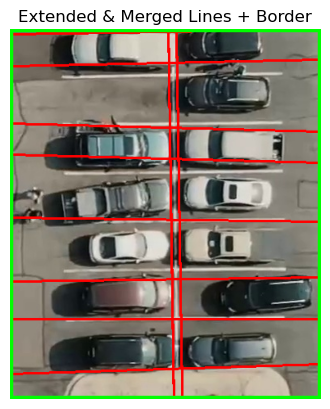

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur before edge detection (increase kernel size for smoother edges)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply Canny edge detection with lower threshold to catch more edges
edges = cv2.Canny(blurred, 50, 200)

# Use morphological operations to close gaps and make edges more continuous
kernel = np.ones((5, 5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

# Use Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw the lines on
line_image = np.copy(image)

# Function to extend lines to the edges of the image (Fixed)
def extend_line(x1, y1, x2, y2, img_width, img_height):
    if x2 - x1 != 0:  # Non-vertical line
        slope = (y2 - y1) / (x2 - x1)
        x1_new, y1_new = 0, int(y1 - slope * x1)  # Extend left
        x2_new = img_width  # Extend to right boundary
        y2_new = int(y1 + slope * (x2_new - x1))
    else:  # Vertical line (undefined slope)
        x1_new, x2_new = x1, x2  # Keep x-values the same
        y1_new, y2_new = 0, img_height  # Extend from top to bottom

    return (x1_new, y1_new, x2_new, y2_new)

# Function to filter and merge horizontal & vertical lines
def filter_and_merge_lines(lines, angle_tol=2, distance_tol=30, img_width=1920, img_height=1080):
    if lines is None:
        return []

    filtered_lines = []
    
    # Filter out horizontal and vertical lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

        if abs(angle) < angle_tol or abs(angle - 180) < angle_tol:  # Horizontal
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, img_width, img_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'h'))
        elif abs(angle - 90) < angle_tol or abs(angle - 270) < angle_tol:  # Vertical
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, img_width, img_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'v'))

    # Merge close lines by checking their distance
    merged_lines = []
    for line in filtered_lines:
        x1, y1, x2, y2, orientation = line
        merged = False
        
        for merged_line in merged_lines:
            mx1, my1, mx2, my2, _ = merged_line
            if orientation == 'h':  # Merge horizontal lines
                if abs(y1 - my1) < distance_tol and abs(y2 - my2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((min(x1, mx1), y1, max(x2, mx2), y2, orientation))
                    merged = True
                    break
            elif orientation == 'v':  # Merge vertical lines
                if abs(x1 - mx1) < distance_tol and abs(x2 - mx2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((x1, min(y1, my1), x2, max(y2, my2), orientation))
                    merged = True
                    break
        
        if not merged:
            merged_lines.append((x1, y1, x2, y2, orientation))
    
    return merged_lines

# Get the filtered and merged lines
merged_lines = filter_and_merge_lines(lines, img_width=image.shape[1], img_height=image.shape[0])

# Draw the detected lines
for line in merged_lines:
    x1, y1, x2, y2, orientation = line
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red lines

# Draw a border around the image
border_color = (0, 255, 0)  # Green border
thickness = 5  # Thickness of the border
cv2.rectangle(line_image, (0, 0), (image.shape[1] - 1, image.shape[0] - 1), border_color, thickness)

# Display the image with extended and merged lines + border
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Extended & Merged Lines + Border")
plt.axis('off')  # Hide axes for better visualization
plt.show()


Bounding box area: 1695732543.7920852


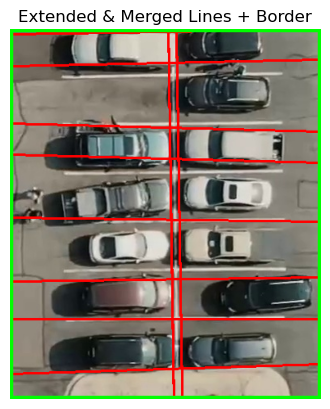

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur before edge detection (increase kernel size for smoother edges)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply Canny edge detection with lower threshold to catch more edges
edges = cv2.Canny(blurred, 50, 200)

# Use morphological operations to close gaps and make edges more continuous
kernel = np.ones((5, 5), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)

# Use Hough Line Transform to detect straight lines
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=150, minLineLength=50, maxLineGap=10)

# Create a copy of the original image to draw the lines on
line_image = np.copy(image)

# Function to extend lines to the edges of the image (Fixed)
def extend_line(x1, y1, x2, y2, img_width, img_height):
    if x2 - x1 != 0:  # Non-vertical line
        slope = (y2 - y1) / (x2 - x1)
        x1_new, y1_new = 0, int(y1 - slope * x1)  # Extend left
        x2_new = img_width  # Extend to right boundary
        y2_new = int(y1 + slope * (x2_new - x1))
    else:  # Vertical line (undefined slope)
        x1_new, x2_new = x1, x2  # Keep x-values the same
        y1_new, y2_new = 0, img_height  # Extend from top to bottom

    return (x1_new, y1_new, x2_new, y2_new)

# Function to filter and merge horizontal & vertical lines
def filter_and_merge_lines(lines, angle_tol=2, distance_tol=30, img_width=1920, img_height=1080):
    if lines is None:
        return []

    filtered_lines = []
    
    # Filter out horizontal and vertical lines
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))

        if abs(angle) < angle_tol or abs(angle - 180) < angle_tol:  # Horizontal
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, img_width, img_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'h'))
        elif abs(angle - 90) < angle_tol or abs(angle - 270) < angle_tol:  # Vertical
            x1_new, y1_new, x2_new, y2_new = extend_line(x1, y1, x2, y2, img_width, img_height)
            filtered_lines.append((x1_new, y1_new, x2_new, y2_new, 'v'))

    # Merge close lines by checking their distance
    merged_lines = []
    for line in filtered_lines:
        x1, y1, x2, y2, orientation = line
        merged = False
        
        for merged_line in merged_lines:
            mx1, my1, mx2, my2, _ = merged_line
            if orientation == 'h':  # Merge horizontal lines
                if abs(y1 - my1) < distance_tol and abs(y2 - my2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((min(x1, mx1), y1, max(x2, mx2), y2, orientation))
                    merged = True
                    break
            elif orientation == 'v':  # Merge vertical lines
                if abs(x1 - mx1) < distance_tol and abs(x2 - mx2) < distance_tol:
                    merged_lines.remove(merged_line)
                    merged_lines.append((x1, min(y1, my1), x2, max(y2, my2), orientation))
                    merged = True
                    break
        
        if not merged:
            merged_lines.append((x1, y1, x2, y2, orientation))
    
    return merged_lines

# Function to find intersection of two lines
def intersection(line1, line2):
    x1, y1, x2, y2 = line1[:4]  # Exclude orientation element
    x3, y3, x4, y4 = line2[:4]  # Exclude orientation element

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Lines are parallel or coincident

    inter_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    inter_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

    return (inter_x, inter_y)

# Find intersection points
intersection_points = []
for i, line1 in enumerate(merged_lines):
    for j, line2 in enumerate(merged_lines):
        if i < j:
            inter_point = intersection(line1, line2)
            if inter_point:
                intersection_points.append(inter_point)

# Draw the detected lines on the image
for line in merged_lines:
    x1, y1, x2, y2, orientation = line
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red lines

# Draw bounding box around the intersection points in blue
if intersection_points:
    min_x = min([point[0] for point in intersection_points])
    max_x = max([point[0] for point in intersection_points])
    min_y = min([point[1] for point in intersection_points])
    max_y = max([point[1] for point in intersection_points])

    # Draw bounding box in blue
    cv2.rectangle(line_image, (int(min_x), int(min_y)), (int(max_x), int(max_y)), (255, 0, 0), 2)  # Blue box

    # Calculate the area of the bounding box
    area = (max_x - min_x) * (max_y - min_y)
    print(f"Bounding box area: {area}")

# Draw a border around the image
border_color = (0, 255, 0)  # Green border
thickness = 5  # Thickness of the border
cv2.rectangle(line_image, (0, 0), (image.shape[1] - 1, image.shape[0] - 1), border_color, thickness)

# Display the image with extended and merged lines + border
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Extended & Merged Lines + Border")
plt.axis('off')  # Hide axes for better visualization
plt.show()


# Trial 2 

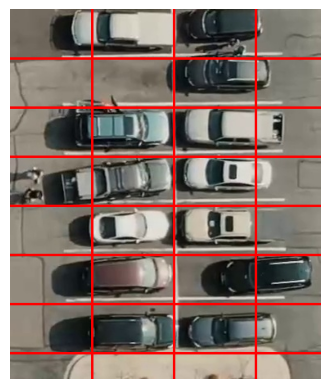

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Draw red horizontal lines spaced every 60 pixels
    for y in range(60, height, 60):
        cv2.line(image, (0, y), (width, y), (0, 0, 255), 2)

    # Draw red vertical lines spaced every 100 pixels
    for x in range(100, width, 100):
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 2)

    # Convert image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


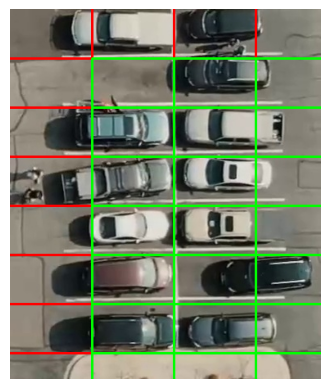

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:/parking/vedioframes/frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Draw red horizontal lines spaced every 60 pixels
    for y in range(60, height, 60):
        cv2.line(image, (0, y), (width, y), (0, 0, 255), 2)

    # Draw red vertical lines spaced every 100 pixels
    for x in range(100, width, 100):
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 2)

    # Extract and draw bounding boxes for each grid cell
    for y in range(60, height, 60):
        for x in range(100, width, 100):
            # Draw rectangle around each cell
            top_left = (x, y)
            bottom_right = (x + 100, y + 60)  # Width = 100, Height = 60 for each cell
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green bounding box

    # Convert image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


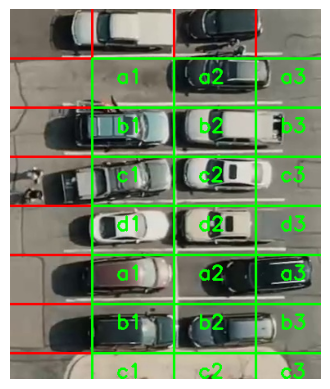

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Draw red horizontal lines spaced every 60 pixels
    for y in range(60, height, 60):
        cv2.line(image, (0, y), (width, y), (0, 0, 255), 2)

    # Draw red vertical lines spaced every 100 pixels
    for x in range(100, width, 100):
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 2)

    # Extract and draw bounding boxes for each grid cell, adding labels
    label_row = ['a', 'b', 'c', 'd']  # You can change this based on the number of rows
    label_col = [str(i+1) for i in range(width // 100)]  # Labels for columns like 1, 2, 3...

    for row_idx, y in enumerate(range(60, height, 60)):
        for col_idx, x in enumerate(range(100, width, 100)):
            # Draw rectangle around each cell
            top_left = (x, y)
            bottom_right = (x + 100, y + 60)  # Width = 100, Height = 60 for each cell
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green bounding box
            
            # Label each slot (e.g., a1, a2, etc.)
            label = label_row[row_idx % len(label_row)] + label_col[col_idx % len(label_col)]
            text_position = (x + 30, y + 30)  # Position to center the text
            cv2.putText(image, label, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Convert image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


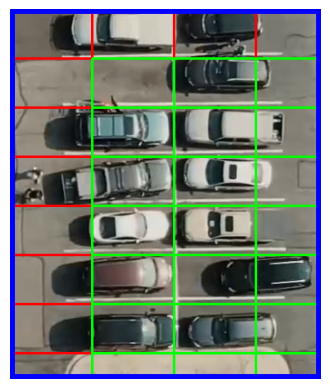

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Draw red horizontal lines spaced every 60 pixels
    for y in range(60, height, 60):
        cv2.line(image, (0, y), (width, y), (0, 0, 255), 2)

    # Draw red vertical lines spaced every 100 pixels
    for x in range(100, width, 100):
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 2)

    # Extract and draw bounding boxes for each grid cell
    for y in range(60, height, 60):
        for x in range(100, width, 100):
            # Draw rectangle around each cell
            top_left = (x, y)
            bottom_right = (x + 100, y + 60)  # Width = 100, Height = 60 for each cell
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green bounding box

    # Add border around the entire image (10px border width)
    border_thickness = 10
    border_color = (255, 0, 0)  # Blue color for the border (BGR format)
    cv2.rectangle(image, (0, 0), (width-1, height-1), border_color, border_thickness)

    # Convert image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


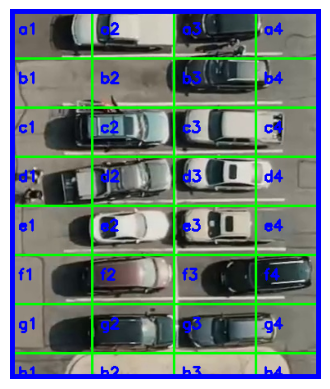

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Define cell width and height
    cell_width = 100
    cell_height = 60

    # Draw red horizontal lines spaced every 60 pixels
    for y in range(cell_height, height, cell_height):
        cv2.line(image, (0, y), (width, y), (0, 0, 255), 2)

    # Draw red vertical lines spaced every 100 pixels
    for x in range(cell_width, width, cell_width):
        cv2.line(image, (x, 0), (x, height), (0, 0, 255), 2)

    # Add labels to each grid cell
    rows = 'abcdefghijklmnopqrstuvwxyz'  # Row labels
    for y in range(0, height, cell_height):  # Start from y = 0 to include top row
        for x in range(0, width, cell_width):  # Start from x = 0 to include left column
            # Draw rectangle around each cell
            top_left = (x, y)
            bottom_right = (x + cell_width, y + cell_height)  # Width = 100, Height = 60 for each cell
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)  # Green bounding box
            
            # Calculate the label for the current cell
            row_label = rows[(y // cell_height)]  # Adjust index to get the correct row label
            col_label = (x // cell_width) + 1  # Adjust index to get the correct column label (starting from 1)
            
            # Create the label (e.g., 'a1', 'b2', etc.)
            label = f"{row_label}{col_label}"
            
            # Set font and position to display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            label_position = (x + 10, y + 30)  # Adjust position for better visibility
            cv2.putText(image, label, label_position, font, 0.6, (255, 0, 0), 2)

    # Add border around the entire image (10px border width)
    border_thickness = 10
    border_color = (255, 0, 0)  # Blue color for the border (BGR format)
    cv2.rectangle(image, (0, 0), (width-1, height-1), border_color, border_thickness)

    # Convert image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


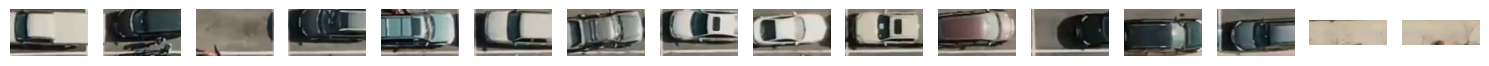

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0029.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Define cell width and height
    cell_width = 100
    cell_height = 60

    # Define rows and columns of interest (rows 'a' to 'h', columns 2 and 3)
    rows = 'abcdefgh'  # Rows 'a' to 'h'
    columns_of_interest = [2, 3]  # Columns 2 and 3

    # Prepare a list to hold cropped images
    cropped_images = []

    # Loop through the grid to extract the images in column 2 and 3 for rows a to h
    for y in range(0, height, cell_height):  # Iterate through rows
        row_label = rows[y // cell_height]  # Calculate the row label
        if row_label not in rows:  # Ensure row is in range a-h
            continue

        for x in range(0, width, cell_width):  # Iterate through columns
            col_label = (x // cell_width) + 1  # Column labels start from 1
            
            # Only consider column 2 and 3
            if col_label in columns_of_interest:
                # Calculate bounding box
                top_left = (x, y)
                bottom_right = (x + cell_width, y + cell_height)
                
                # Crop the image
                cropped_image = image[y:y + cell_height, x:x + cell_width]

                # Append the cropped image to the list
                cropped_images.append(cropped_image)

    # Plot the cropped images in a grid
    fig, axes = plt.subplots(1, len(cropped_images), figsize=(15, 5))
    if len(cropped_images) == 1:  # If only one image, axes will not be an array
        axes = [axes]
    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')  # Hide axes for better display
    plt.tight_layout()
    plt.show()


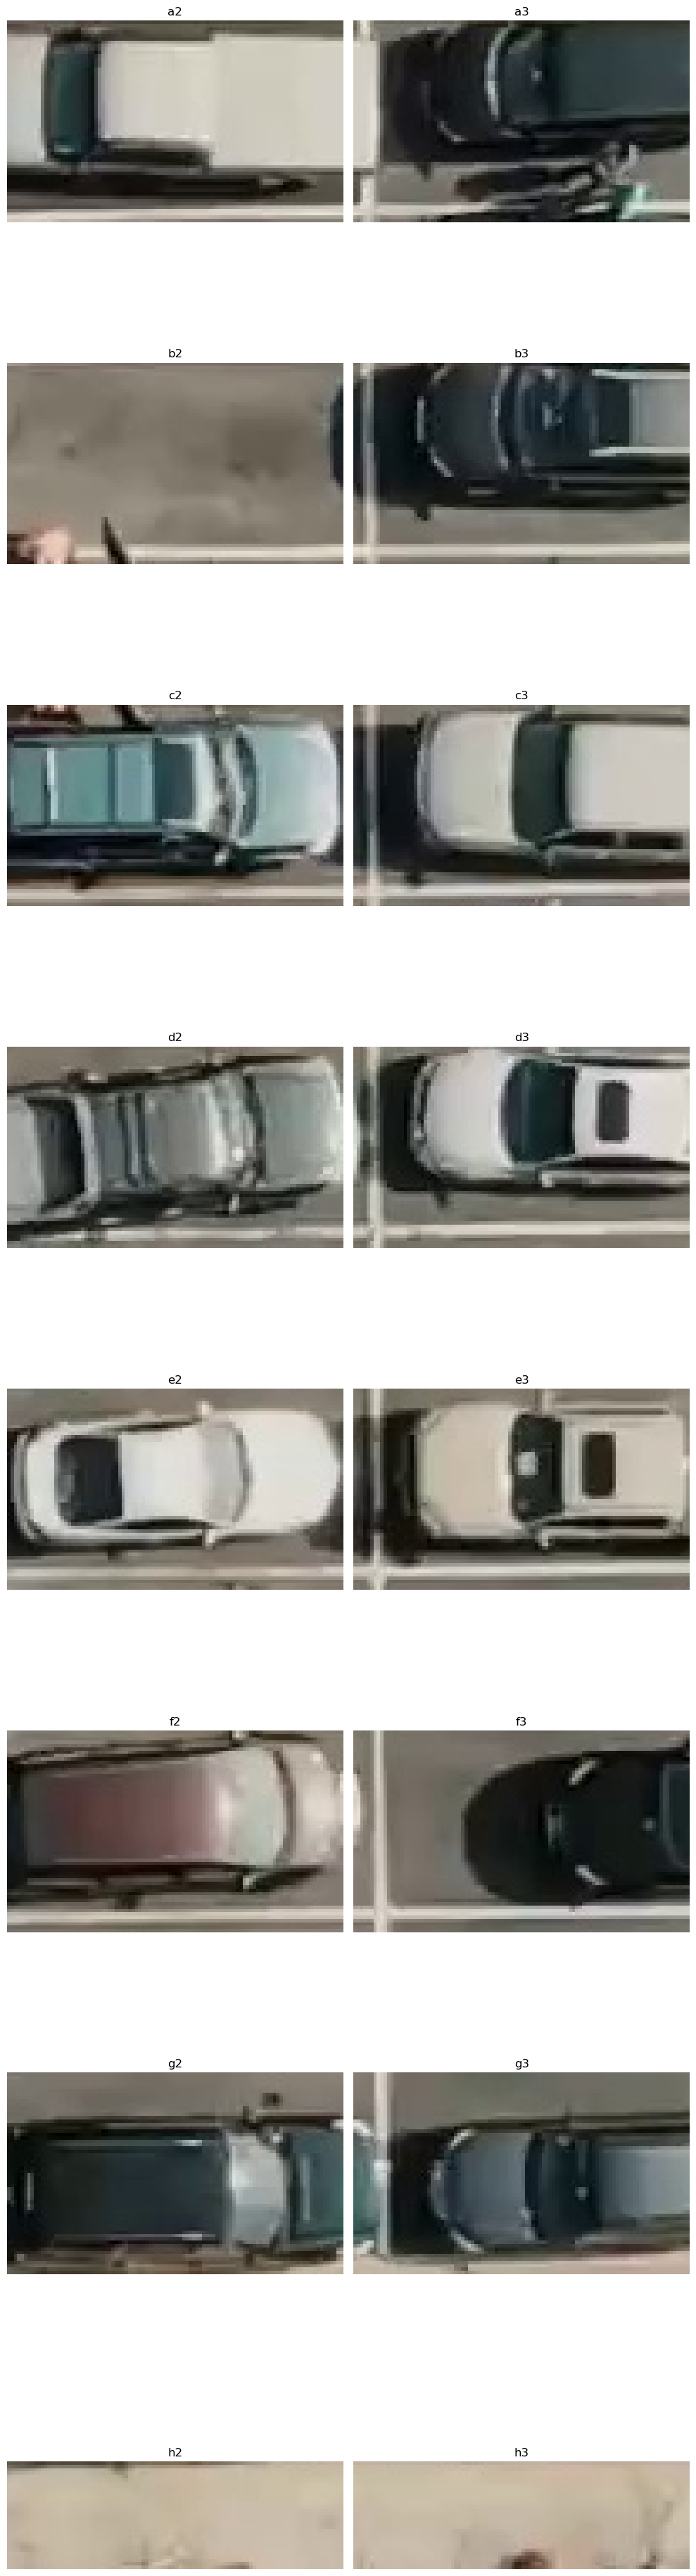

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (ensure the path is correct)
image_path = "D:\\final year project\\new parking\\parking\\vedioframes\\frame_0001.jpg"  # Use forward slashes or raw string literals
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error loading image. Please check the file path.")
else:
    # Get image dimensions
    height, width, _ = image.shape

    # Define cell width and height
    cell_width = 100
    cell_height = 60

    # Define rows and columns of interest (rows 'a' to 'h', columns 2 and 3)
    rows = 'abcdefgh'  # Rows 'a' to 'h'
    columns_of_interest = [2, 3]  # Columns 2 and 3

    # Prepare a list to hold cropped images and their titles
    cropped_images = []
    image_titles = []

    # Loop through the grid to extract the images in column 2 and 3 for rows a to h
    for y in range(0, height, cell_height):  # Iterate through rows
        row_label = rows[y // cell_height]  # Calculate the row label
        if row_label not in rows:  # Ensure row is in range a-h
            continue

        for x in range(0, width, cell_width):  # Iterate through columns
            col_label = (x // cell_width) + 1  # Column labels start from 1
            
            # Only consider column 2 and 3
            if col_label in columns_of_interest:
                # Calculate bounding box
                top_left = (x, y)
                bottom_right = (x + cell_width, y + cell_height)
                
                # Crop the image
                cropped_image = image[y:y + cell_height, x:x + cell_width]

                # Create the notation (e.g., 'a2', 'a3', 'b2', 'b3')
                label = f"{row_label}{col_label}"

                # Append the cropped image and label to the list
                cropped_images.append(cropped_image)
                image_titles.append(label)

    # Plot the cropped images in a grid (2 images per row)
    num_images = len(cropped_images)
    num_rows = (num_images + 1) // 2  # Number of rows, 2 images per row

    fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 5))

    # If there's only one row, axes will not be a 2D array, so we handle that case
    if num_rows == 1:
        axes = [axes]

    for i, ax in enumerate(axes.flat):  # Flatten axes for easy iteration
        if i < num_images:  # Check if there are still images to display
            ax.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
            ax.set_title(image_titles[i])  # Set the title with the notation
            ax.axis('off')  # Hide axes for better display
        else:
            ax.axis('off')  # Hide empty axes if the number of images is odd

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


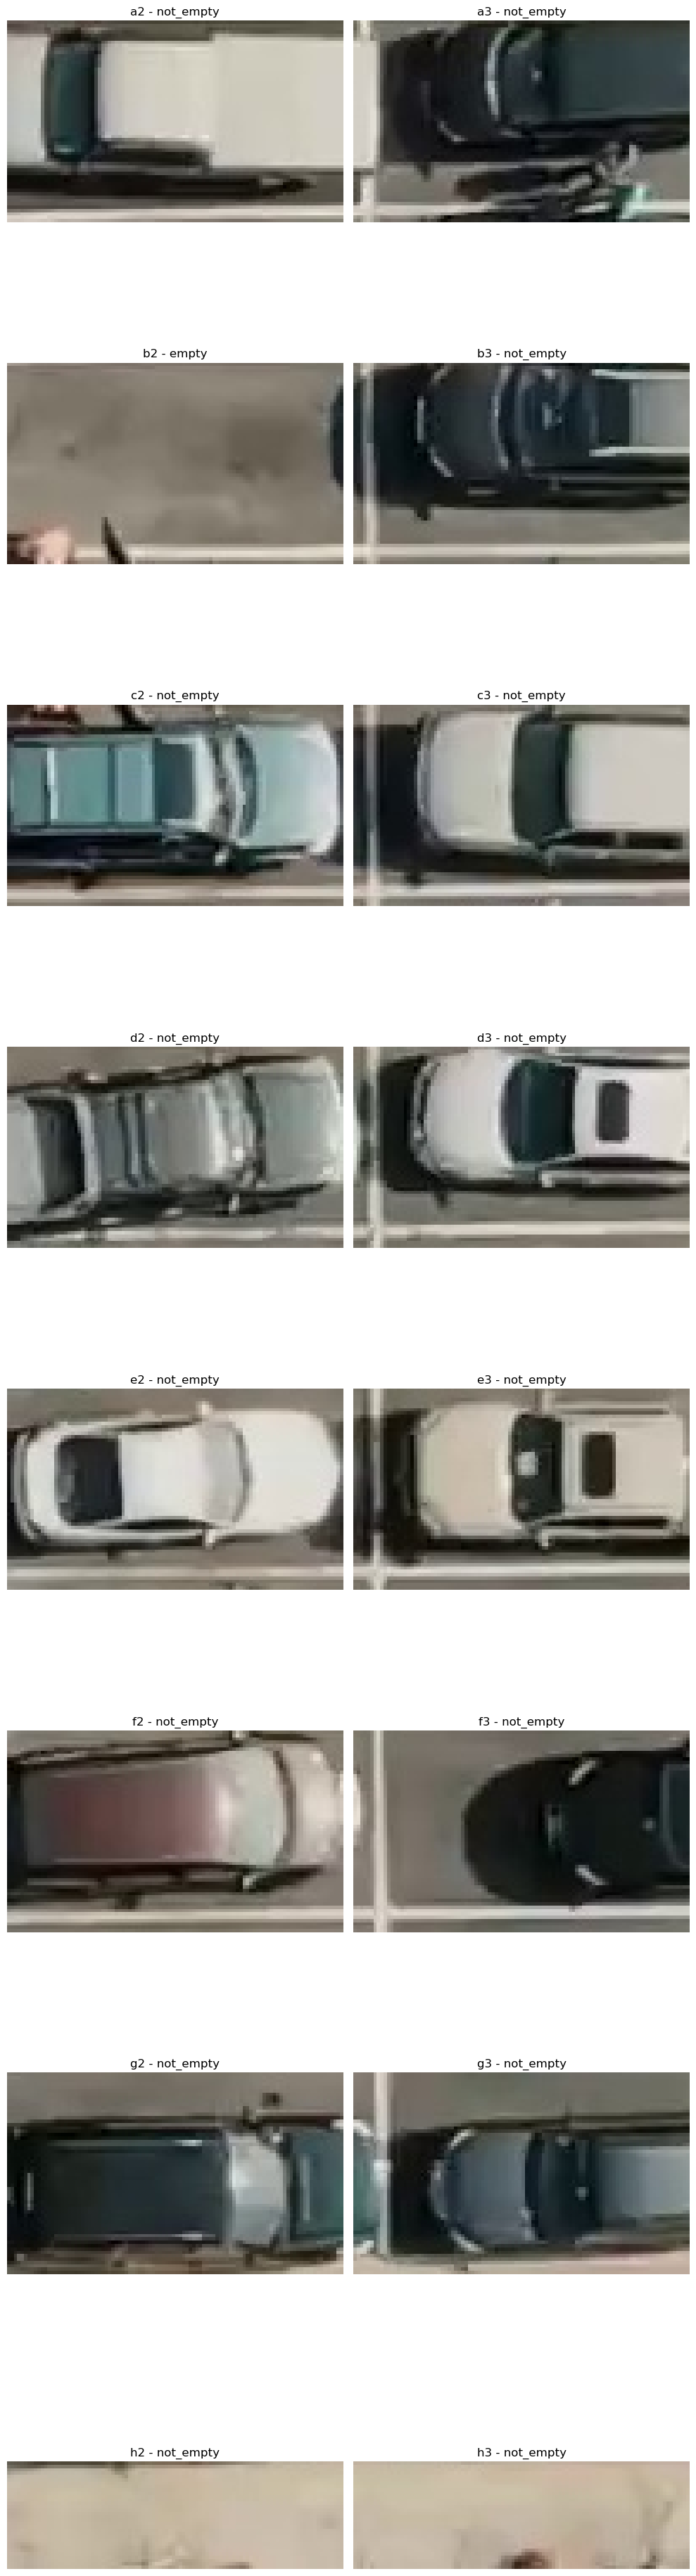

In [20]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_model.h5')

# Define image preprocessing function to match model input
def preprocess_image(image):
    # Resize the image to 128x128 (as per model input size)
    image_resized = cv2.resize(image, (128, 128))
    
    # Convert to grayscale (assuming the model uses single-channel images)
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    
    # Normalize the image to [0, 1] range
    image_normalized = image_gray / 255.0
    
    # Reshape the image to match model input shape (128, 128, 1)
    image_input = np.expand_dims(image_normalized, axis=-1)
    
    return np.expand_dims(image_input, axis=0)  # Add batch dimension

# List to store predictions
predictions = []

# Loop through each cropped image and predict
for i, cropped_image in enumerate(cropped_images):
    # Preprocess the image
    processed_image = preprocess_image(cropped_image)
    
    # Predict using the model
    prediction = model.predict(processed_image)
    
    # Map prediction to labels (0: empty, 1: not_empty)
    label = 'not_empty' if prediction > 0.5 else 'empty'
    
    predictions.append(label)

# Plot the cropped images with their predictions
num_images = len(cropped_images)
num_rows = (num_images + 1) // 2  # Number of rows, 2 images per row

fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 5))

# If there's only one row, axes will not be a 2D array, so we handle that case
if num_rows == 1:
    axes = [axes]

for i, ax in enumerate(axes.flat):  # Flatten axes for easy iteration
    if i < num_images:  # Check if there are still images to display
        ax.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
        ax.set_title(f"{image_titles[i]} - {predictions[i]}")  # Display prediction along with notation
        ax.axis('off')  # Hide axes for better display
    else:
        ax.axis('off')  # Hide empty axes if the number of images is odd

plt.tight_layout()
plt.show()


In [2]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('cnn_model.h5')

# Define image preprocessing function to match model input
def preprocess_image(image):
    image_resized = cv2.resize(image, (128, 128))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_normalized = image_gray / 255.0
    image_input = np.expand_dims(image_normalized, axis=-1)
    return np.expand_dims(image_input, axis=0)

# Prediction function for each cropped image
def predict_image(image):
    image = np.array(image)
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    label = 'parked' if prediction > 0.5 else 'empty'
    return label

# Function to extract cropped images from the uploaded image
def extract_and_predict(image):
    image = np.array(image)
    height, width, _ = image.shape

    cell_width = 100
    cell_height = 60

    rows = 'abcdefgh'
    columns_of_interest = [2, 3]

    overlay = image.copy()

    for y in range(0, height, cell_height):
        for x in range(0, width, cell_width):
            col_label = (x // cell_width) + 1
            if col_label in columns_of_interest:
                cropped_image = image[y:y + cell_height, x:x + cell_width]
                prediction = predict_image(cropped_image)
                color = (0, 255, 0) if prediction == 'empty' else (0, 0, 255)
                cv2.rectangle(overlay, (x, y), (x + cell_width, y + cell_height), color, -1)

    # Blend overlay with original image to create transparency
    cv2.addWeighted(overlay, 0.4, image, 0.6, 0, image)

    output_path = 'highlighted_parking_image.png'
    cv2.imwrite(output_path, image)

    return output_path

# Create the Gradio interface
interface = gr.Interface(fn=extract_and_predict,
                         inputs=gr.Image(type="pil", label="Upload Image"),
                         outputs=gr.Image(type="filepath", label="Predictions"),
                         live=True,
                         title="Parking Detection from Grid Images",
                         description="Upload an image, and the model will extract grid images and classify them as 'parking' or 'not parking'.",
                         theme="huggingface")

# Launch the app
interface.launch()


C:\Users\kisha\anaconda3\lib\site-packages\gradio\blocks.py:1096: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67e624e3-3c8c38a65e984e6555ed545a;8a5b2ca2-a3a8-40cb-acac-f31b7f40a524)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [1]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
import time

# Load the trained model
model = tf.keras.models.load_model('cnn_model.h5')

# Dictionary to track parking spot states and their durations
parking_status = {}

# Time interval for tracking (10 seconds)
TIME_INTERVAL = 10

# Rate for billing (per session)
BILL_RATE = 20

def preprocess_image(image):
    image_resized = cv2.resize(image, (128, 128))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    image_normalized = image_gray / 255.0
    image_input = np.expand_dims(image_normalized, axis=-1)
    return np.expand_dims(image_input, axis=0)

def predict_image(image):
    image = np.array(image)
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    label = 'parked' if prediction > 0.5 else 'empty'
    return label

def extract_and_predict(video_path):
    cap = cv2.VideoCapture(video_path)
    text_output = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % (TIME_INTERVAL * cap.get(cv2.CAP_PROP_FPS)) == 0:
            height, width, _ = frame.shape
            cell_width = 100
            cell_height = 60

            rows = 'abcdefgh'

            current_status = []

            for y in range(0, height, cell_height):
                for x in range(0, width, cell_width):
                    col_label = (x // cell_width) + 1
                    row_label = rows[y // cell_height]
                    spot_label = f"{row_label}{col_label}"

                    cropped_image = frame[y:y + cell_height, x:x + cell_width]
                    prediction = predict_image(cropped_image)
                    current_status.append(f"{spot_label}:{prediction}")

                    # Track status and update time
                    if spot_label not in parking_status:
                        parking_status[spot_label] = {'state': prediction, 'time': time.time()}
                    else:
                        if parking_status[spot_label]['state'] == 'parked' and prediction == 'empty':
                            duration = int(time.time() - parking_status[spot_label]['time'])
                            bill = BILL_RATE
                            text_output.append(f"{spot_label} {parking_status[spot_label]['state']}:{duration} Bill={bill} rs")
                            parking_status[spot_label] = {'state': prediction, 'time': time.time()}
                        elif parking_status[spot_label]['state'] != prediction:
                            parking_status[spot_label] = {'state': prediction, 'time': time.time()}

            text_output.append(f"t={frame_count // (TIME_INTERVAL * cap.get(cv2.CAP_PROP_FPS))} " + ', '.join(current_status))

        frame_count += 1

    cap.release()

    # Return text info on parking times
    return '\n'.join(text_output)

# Create the Gradio interface
interface = gr.Interface(fn=extract_and_predict,
                         inputs=gr.Video(label="Upload Video"),
                         outputs=gr.Text(label="Parking Times"),
                         live=True,
                         title="Parking Detection from Video",
                         description="Upload a video, and the model will extract frames and classify parking spots as 'parking' or 'not parking', tracking durations.",
                         theme="huggingface")

# Launch the app
interface.launch()


C:\Users\kisha\anaconda3\lib\site-packages\gradio\blocks.py:1096: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67e62461-7bfab693538a8c8577a4e15a;ffc49d0e-c261-40ec-8df0-575a8ba4a5ed)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
